<a href="https://colab.research.google.com/github/psukphranee/Machine-Learning-Projects/blob/master/Machine%20Learning%20-%20Python/Chapter%203%3A%20Classification/Classification_draft_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification

In [1]:
#pull MNIST dataset from OpenML
from sklearn.datasets import fetch_openml

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np

In [2]:
mnist = fetch_openml(name="mnist_784", as_frame=False)
display(mnist.keys())
X = mnist.data #70,000 x 784
y = mnist.target #70,000 x 1


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
#convert y to integers, they come as strings
y = y.astype(np.uint8)

In [4]:
#Before moving forward, split the data into training test sets. This dataset comes shuffled and the first 60,000 samples are the training set.
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [5]:
#define a function to plot digits
def plot_digits(instances, images_per_row=10, **options):

  size = 28 # 28 x 28 images
  img_per_row = min(len(instances), images_per_row)

  #calculate number of rows needed
  #this is equivalent to ceil(len(instances)/img_per_row) although I'm not sure how.
  #going to read up on this in a discrete math book
  n_rows = (len(instances) + 1) // (img_per_row - 1) 
  print(img_per_row, "rows: ", n_rows)

  #in case the instances are less than number of rows * the images per row, we'll pad them with zeros
  #of 28 x 28 dimension. the rows of padded_instances are images flattened out. 
  n_padding = (n_rows * img_per_row) - len(instances)
  padded_instances = np.concatenate([instances, np.zeros((n_padding, size * size))], axis=0)

  #we perform a reshaping of the padded_instances. each row in padded_instances will fill a 28x28 (size x size)
  #square. there are n_row * img_per_row of these squares. e.g. the element num_grid[0,0] contains a 28x28
  #ndarray of numbers corresponding to the first row of instances
  num_grid = padded_instances.reshape(n_rows, img_per_row, size, size)
  

  #num_grid is a 4D array that needs to be mapped to a 2D array before rendering. 
  #We will have to modify the way the 4D array is indexed, by using the function transpose(), prior to mapping it using reshape().
  #ex) num_grid(0,1,12,18) is the (12,18) pixel of image (0,1)
  #the operation transpose(0,2,1,3) will modify the index so that the first two indices are rows and last two are columns
  #of the image grid and pixels, respectively. For example, the incrementing indices (0,0,0,0) -> (0,0,0,1) -> (0,0,0,2)
  #will sweep across the first row of pixels of images num_grid's first row. 
  num_grid_2D = num_grid.transpose(0,2,1,3).reshape(n_rows * size, img_per_row * size)

  plt.imshow(num_grid_2D, cmap=mpl.cm.binary, **options)
  plt.axis("off")


10 rows:  11


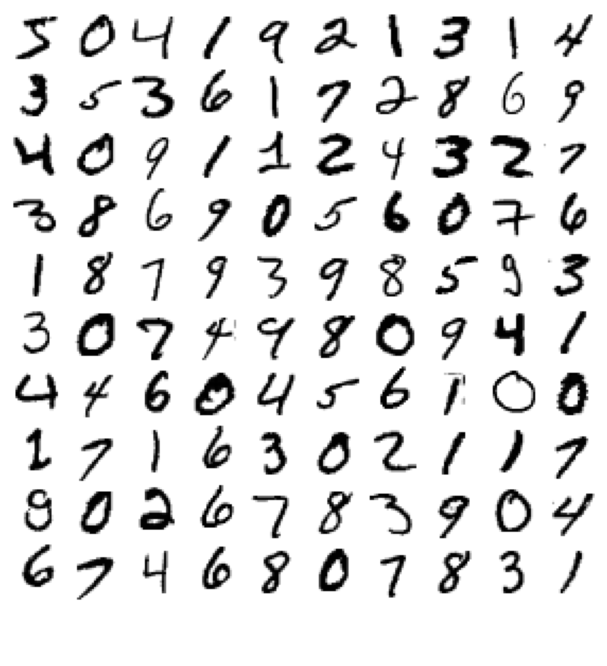

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
       3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5,
       6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9,
       0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1], dtype=uint8)

In [6]:
#plot digits
plt.figure(figsize=(12,12))
sample_digits = X_train[:100]
sample_labels = y_train[:100]
plot_digits(sample_digits, images_per_row=10)
plt.show()
display(sample_labels)

Train a binary classifier and discuss Performance Measures. 
* Accuracy: not favorable for classification because of skewed datasets
* Confusion Matrix
* Precision and Recall
* F1 is the harmonic mean of precion and recall

* Examine Precision vs Recall Curve
* Examine ROC Curve


In [7]:
#We're going to train a binary classifier to determine whether a sample is 5 or not
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

## Accuracy and Why It's Not a Good Performance Measure for Classification


In [8]:
'''
Accuracy isn't a good performance measure for classification models because of the possibly of having a skewed dataset.
For example, having a training set with a few 5's and much much more other numbers that is trained on a model that always predicts non-5's will trivially score high.
We'll demonstrate this by creating a model that always predicts non-5's
'''

#create a model that never predicts 5's
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    pass
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [9]:
#We'll train our model using cross validation on 3 folds using sklearn's out-of-box function.
#We'll evaluate the performance of this model using accuracy. It scors trivially high because
#most of the digits in the training set are not 5's.

from sklearn.model_selection import cross_val_score

nv5_clf = Never5Classifier()
scores = cross_val_score(nv5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
display(scores)

array([0.91125, 0.90855, 0.90915])

## Precision and Recall

We train a SGD Classifier on cross validation 3 folds and output the model's predictions on whether or not a number is a 5. We feed this output and the labels into a function that compares the predictions to actual values and generates a confusion matrix. The function bins our predictions into four categories: True Negative (TN), False Positive (FP), False Negative (FN), True Positive (TP). These category counts are tabulated into an array in that order.

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict

sgd_clf = SGDClassifier()
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

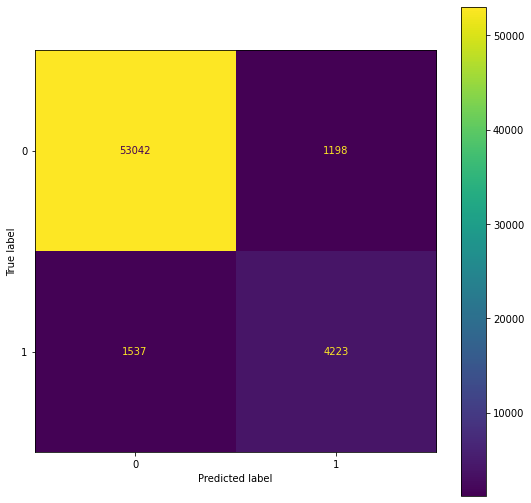

In [42]:
sgd_conf = confusion_matrix(sgd_pred, y_train_5)
sgd_conf_disp = ConfusionMatrixDisplay(sgd_conf)

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
sgd_ax = sgd_conf_disp.plot(ax=ax)

## Precision and Recall

Precision answers the question: Out of all the samples predicted to be posiitve, what portion is actually positive?

$$\text{Precision} = \dfrac{TP}{TP+FP}$$

Recall answers the question: Out of all actual positive samples, how many were labeled as such?

$$\text{Recall} = \dfrac{TP}{TP+FN}$$

The SGD Classifier is a linear model that classifies each sample based on their prediction score. It determines true or false based on some threshold. 


In [43]:
sgd_pred[:10]

array([ True, False, False, False, False, False, False, False, False,
       False])

We'll output the prediction scores instead of the predicted class by specifing the "method' parameter in the cross_val_predict function. With these scores, we can play around with different threshold's to see how it affects precision and recall.

In [ ]:
sgd_clf_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [47]:
from scipy import stats

stats.describe(sgd_clf_scores)

DescribeResult(nobs=60000, minmax=(-125754.81505525978, 33702.9867330596), mean=-12324.491393912493, variance=126922733.02187939, skewness=-1.1245439789035805, kurtosis=5.058156126367884)

In [48]:
#sklearn has a function that tries out different values for the threshold and calculates their corresponding recall and precision. 
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, sgd_clf_scores)

We plot the recall and precision against a range of thresholds and see that theres a trade-off between the two quantites.

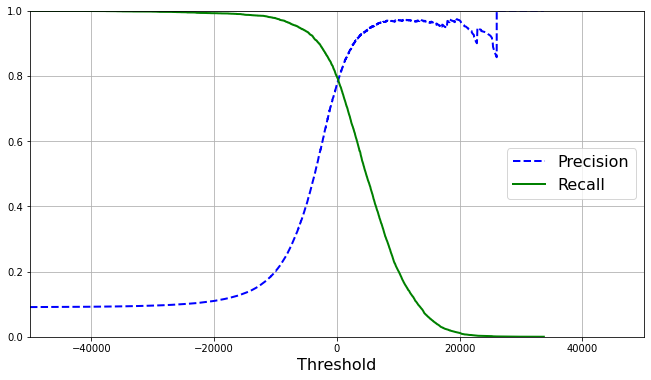

In [85]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.figure(figsize=(11, 6))
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
  plt.legend(loc="center right", fontsize=16) # Not shown in the book
  plt.xlabel("Threshold", fontsize=16)        # Not shown
  plt.grid(True)                              # Not shown
  plt.axis([-50000, 50000, 0, 1])  

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

## ROC Curve

The ROC Curve plots the True Positive Rate vs False Positive Rate. 

$$\frac{TP}{TP + FN} \text{ vs } \frac{FP}{TN + FP}$$

This curve views our predictions from the viewpoint of positive labels. We want to maximize the number of truly positive samples recalled into the set of positive lables meanwhile minimizing including mistakenly false ones. 

In [99]:
## ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, sgd_clf_scores)

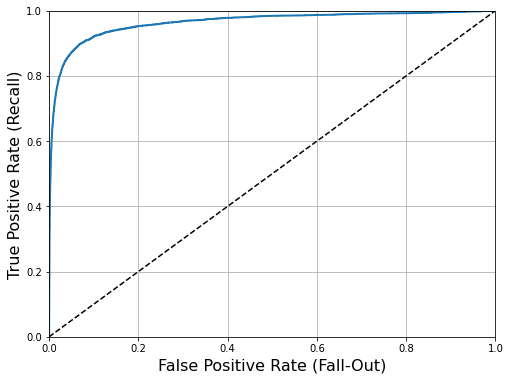

In [100]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)                                  # Not shown
plt.show()

In [ ]:
re

The diagonal line represents a random classifier. The samples that are randomly labeled as positive should reflect the dataset's actual True/False proportion. So the portion it selects from each actual class should be the same, hence the line of slope 1. 

The blue curve is our SGD classifier. As the threshold is increased, the model recalls a higher portion of the actual True samples. The FPR rate increases as well, initially only slightly relative to the FPR however. This reflects that some False samples being labeled True as we recall more samples. 

ROC curves that run closer to the upper right edge of the plot window correspond to better models. Such graphs show that their corresponding model's recall is increasing faster than their FPR. 

We can quantify the characteristic of how close to the edge a curve runs by it's area. Thus, models with more area under their ROC curve are better.